### Required Libraries python

In [10]:
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

### Define Dataset Path and Preprocessing

In [2]:
# Define dataset path
DATASET_PATH = 'covid-19_radiography_dataset'

# Check categories
dir_list = os.listdir(DATASET_PATH)
print("Dataset categories:", dir_list)

# Count number of images in each category
num_of_images = []
for category in dir_list:
    category_path = os.path.join(DATASET_PATH, category)
    num_of_images.append(len(os.listdir(category_path)))
    print(f"{category}: {len(os.listdir(category_path))} images")

# Split dataset into train, validation, and test sets
OUTPUT_PATH = 'dataset_subsets'

if not os.path.exists(OUTPUT_PATH):
    splitfolders.ratio(DATASET_PATH, OUTPUT_PATH, seed=42, ratio=(0.7, 0.1, 0.2))


Dataset categories: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
COVID: 3616 images
Lung Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


### Define Data Loaders

In [3]:
# Define image parameters
IMG_DIMS = 224
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'

# Define dataset directories
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
VALID_PATH = os.path.join(OUTPUT_PATH, 'val')
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True
)

# No augmentation for validation and test sets, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=42)

val_gen = val_test_datagen.flow_from_directory(
    VALID_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=42)

test_gen = val_test_datagen.flow_from_directory(
    TEST_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, shuffle=False)

Found 14814 images belonging to 4 classes.
Found 2115 images belonging to 4 classes.
Found 4236 images belonging to 4 classes.


### Define the Attention CNN Model

In [4]:
def AttentionBlock(inputs):
    attention = layers.Conv2D(64, kernel_size=1, activation='relu')(inputs)
    attention = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

def build_attention_cnn(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Attention Block
    x = AttentionBlock(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Attention_CNN")
    return model

# Build and compile the model
input_shape = (224, 224, 3)
num_classes = len(dir_list)  # Number of categories
model = build_attention_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "Attention_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      8,256 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56, 1) │         65 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ multiply[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 200704)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 51,380,480 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,760,645 (197.45 MB)

 Trainable params: 51,760,645 (197.45 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [5]:
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25


c:\Users\Thy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 1779s 4s/step - accuracy: 0.5673 - loss: 1.0359 - val_accuracy: 0.7362 - val_loss: 0.6430
Epoch 2/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1532s 3s/step - accuracy: 0.7069 - loss: 0.7122 - val_accuracy: 0.7820 - val_loss: 0.5558
Epoch 3/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1523s 3s/step - accuracy: 0.7495 - loss: 0.6143 - val_accuracy: 0.7991 - val_loss: 0.5170
Epoch 4/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1522s 3s/step - accuracy: 0.7832 - loss: 0.5544 - val_accuracy: 0.8288 - val_loss: 0.4501
Epoch 5/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1524s 3s/step - accuracy: 0.8008 - loss: 0.5192 - val_accuracy: 0.8255 - val_loss: 0.4481
Epoch 6/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1513s 3s/step - accuracy: 0.8143 - loss: 0.4834 - val_accuracy: 0.8492 - val_loss: 0.4053
Epoch 7/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1543s 3s/step - accuracy: 0.8254 - loss: 0.4522 - val_accuracy: 0.8539 - val_loss: 0.3745
Epoch 8/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1543s 3s/step - accuracy: 0.8408 - loss: 0.4180 - val_accurac

### Evaluate the Model

133/133 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9167 - loss: 0.2391
Test Accuracy: 0.9131
133/133 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step
                 precision    recall  f1-score   support

          COVID       0.97      0.93      0.95       724
   Lung Opacity       0.86      0.89      0.88      1203
         Normal       0.92      0.92      0.92      2039
Viral Pneumonia       0.99      0.90      0.94       270

       accuracy                           0.91      4236
      macro avg       0.93      0.91      0.92      4236
   weighted avg       0.91      0.91      0.91      4236



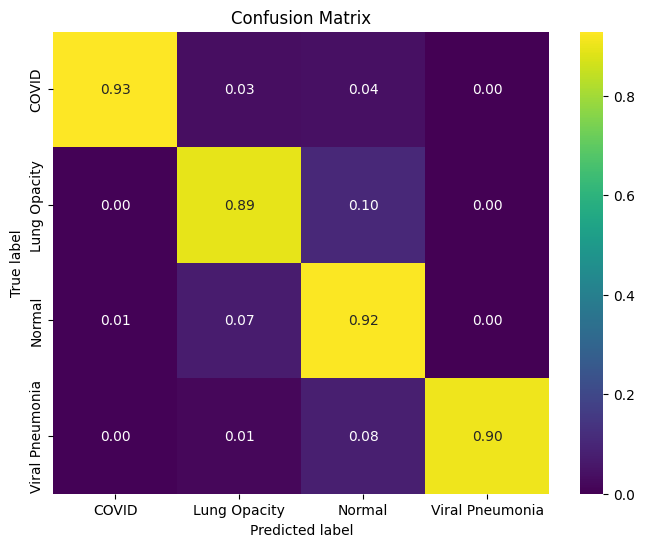

In [11]:
# Evaluate model on test data
from sklearn.metrics import ConfusionMatrixDisplay


test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate predictions
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='pred')

# Create a figure and axis for Confusion Matrix Display
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=75)

# Generate the confusion matrix plot
ConfusionMatrixDisplay.from_predictions(true_classes,
                                        predicted_classes,
                                        display_labels=class_labels,
                                        include_values=True,
                                        normalize='pred',
                                        values_format='.2f',
                                        cmap='viridis',
                                        ax=ax)

# Improve visualization
plt.tick_params(left=False, bottom=False)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=30)

# Save figure
plt.savefig('figures/confusion_matrix.png', dpi=200)

# Show the plot
plt.show()

### Save the Model

In [ ]:
model.save("attention_cnn_pneumonia.h5")